In [1]:
import os
from collections import defaultdict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp

FONTDICT = {
    'family': 'serif', 
    'color': 'black', 
    'weight': 'normal', 
    'size': 12
}

In [2]:
def get_results(dataset, models):

    valid_models = set(models)
    results = defaultdict(list)

    for model in valid_models.copy():

        exp_dir = f'./results/{dataset}/{model}'
        for run in os.listdir(exp_dir):
            run_dir = f'{exp_dir}/{run}'
            if os.path.isdir(run_dir):
                results[model].append(dict())
                for split in ('training', 'validation', 'testing'):
                    fn = f'{run_dir}/{split}_results.pkl'
                    if os.path.isfile(fn):
                        with open(fn, 'rb') as f:
                            results[model][-1][split] = dict(pickle.load(f))
                if not results[model][-1]:
                    results[model].pop()
    
    return dict(results), tuple(valid_models)

def loss(data, idxs, jump):
    ys = list()
    for idx in idxs:
        loss = sum(data['loss'][idx-jump:idx])
        tp, tn, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['tn'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        ys.append(loss / (tp+tn+fp+fn))
    return ys

def accuracy(data, idxs, jump):
    ys = list()
    for idx in idxs:
        tp, tn, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['tn'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        acc = (tp+tn) / (tp+tn+fp+fn)
        ys.append(acc)
    return ys

def f1_score(data, idxs, jump):
    ys = list()
    for idx in idxs:
        tp, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        f1 = (tp+tp) / (tp+tp+fp+fn)
        ys.append(f1)
    return ys

fn_map = {
    'Loss': loss,
    'Accuracy': accuracy,
    'F1-Score': f1_score
}

models = ['ALBERT', 'BERT', 'BERTweet', 'CT-BERT', 'DistilBERT', 'Longformer', 'RoBERTa', 'Twitter-RoBERTa', 'XLM', 'XLM-RoBERTa', 'XLNet',]
pairs = (
    ('CT-BERT', 'Twitter-RoBERTa'), 
    ('CT-BERT-NT', 'Twitter-RoBERTa-NT'), 
    ('CT-BERT', 'CT-BERT-NT'), 
    ('Twitter-RoBERTa', 'Twitter-RoBERTa-NT'),
)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from model_classes import modelclass_map
from data_classes.preprocess import PreProcessor

preprocessor = PreProcessor()
parameters = dict()

for model_name in os.listdir('config/models'):
    if model_name.startswith('bart'): continue
    with open(f'config/models/{model_name}', 'r') as f:
        hf_path = f.readline().split("'")[1]
        f.readline(); save_name = f.readline().split("'")[1]
        tokenizer = AutoTokenizer.from_pretrained(hf_path)
        tokenizer.add_tokens(preprocessor.TOKENS)
        base_model = AutoModelForSequenceClassification.from_pretrained(hf_path)
        model = modelclass_map(model_name.rstrip('.yaml'))(
            base_model=base_model,
            emb_table_size=len(tokenizer),
            dense_size=18
        )
        parameters[save_name] = model.n_params

In [4]:
print(f'parameters = {parameters}')

parameters = {'ALBERT': [11685762, 11699586], 'BERT': [109487618, 109501442], 'BERTweet': [134905346, 134919170], 'CT-BERT': [335149058, 335167490], 'DistilBERT': [66958850, 66972674], 'Longformer': [148664834, 148678658], 'RoBERTa': [124651010, 124664834], 'Twitter-RoBERTa': [124651010, 124664834], 'XLM': [667103234, 667103270], 'XLM-RoBERTa': [278049026, 278062850], 'XLNet': [117314306, 117328130]}


In [3]:
parameters = {'ALBERT': [11685762, 11699586], 'BERT': [109487618, 109501442], 'BERTweet': [134905346, 134919170], 'CT-BERT': [335149058, 335167490], 'DistilBERT': [66958850, 66972674], 'Longformer': [148664834, 148678658], 'RoBERTa': [124651010, 124664834], 'Twitter-RoBERTa': [124651010, 124664834], 'XLM': [667103234, 667103270], 'XLM-RoBERTa': [278049026, 278062850], 'XLNet': [117314306, 117328130]}

In [4]:
for k, v in parameters.items():
    print(k.ljust(15, ' '), f'{v[0]/10**6:.3f}M'.rjust(8, " "))

ALBERT           11.686M
BERT            109.488M
BERTweet        134.905M
CT-BERT         335.149M
DistilBERT       66.959M
Longformer      148.665M
RoBERTa         124.651M
Twitter-RoBERTa 124.651M
XLM             667.103M
XLM-RoBERTa     278.049M
XLNet           117.314M


In [14]:
datasets = (
    'aaai-constraint-covid',
    'aaai-constraint-covid-appended',
)

index = sorted(models)
metric = 'Accuracy'
jump = 1

# dataframe = defaultdict(lambda: defaultdict(list))
dataframe = defaultdict(list)

for dataset in datasets:
    col_name = dataset.replace('aaai-constraint-covid', 'acc')
    results, _ = get_results(dataset, index)
    for model in index:
        scores = list()
        for run in results[model]:
            val_data = run['validation']
            idxs = list(range(jump, len(val_data['batch'])+jump, jump))
            val_metrics = fn_map[metric](val_data, idxs, jump)
            best_val_metric = max(val_metrics)
            test_data = run['testing']
            test_metrics = fn_map[metric](test_data, idxs, jump)
            best_test_metric = 0.
            for val_metric, test_metric in zip(val_metrics, test_metrics):
                if val_metric == best_val_metric:
                    best_test_metric = max(test_metric, best_test_metric)
            scores.append(best_test_metric)
        dataframe[col_name].append((np.mean(scores), np.std(scores)))
        # dataframe[col_name][model] = scores
        # dataframe[col_name].extend(scores)

df = pd.DataFrame(
    # dict({dataset: values for dataset, values in dataframe.items()}),
    # index=[y for x in ([model, *('' for _ in range(4))] for model in index) for y in x]
    dict(
        **{
            dataset: [f'{100*(1-mean):.3f} \pm {100*std:.3f}' for (mean, std) in values]
            for dataset, values in dataframe.items()
        }, 
        improvement = [100*(y[0]-x[0])/(1-x[0]) for x, y in zip(dataframe['acc'], dataframe['acc-appended'])]
    ),
    index=index
)

df.style.set_properties(**{'text-align': 'right'})

,acc,acc-appended,improvement
ALBERT,3.374 \pm 0.157,2.991 \pm 0.107,11.357341
BERT,3.215 \pm 0.197,2.748 \pm 0.100,14.534884
BERTweet,2.869 \pm 0.063,2.607 \pm 0.130,9.120521
CT-BERT,2.111 \pm 0.128,1.815 \pm 0.078,14.022140
DistilBERT,3.084 \pm 0.170,2.776 \pm 0.063,10.000000
Longformer,3.402 \pm 0.190,2.888 \pm 0.080,15.109890
RoBERTa,3.196 \pm 0.224,2.804 \pm 0.221,12.280702
Twitter-RoBERTa,2.944 \pm 0.042,2.720 \pm 0.108,7.619048
XLM,3.299 \pm 0.308,2.710 \pm 0.139,17.847025
XLM-RoBERTa,2.869 \pm 0.096,2.570 \pm 0.122,10.423453


In [19]:
sorted_index = sorted(list(parameters.items()), key = lambda x: x[1][0])

acc = [dataframe['acc'][index.index(model)][0] for model, _ in sorted_index]
acc_app = [dataframe['acc-appended'][index.index(model)][0] for model, _ in sorted_index]
params = [p for _, (p, _) in sorted_index]

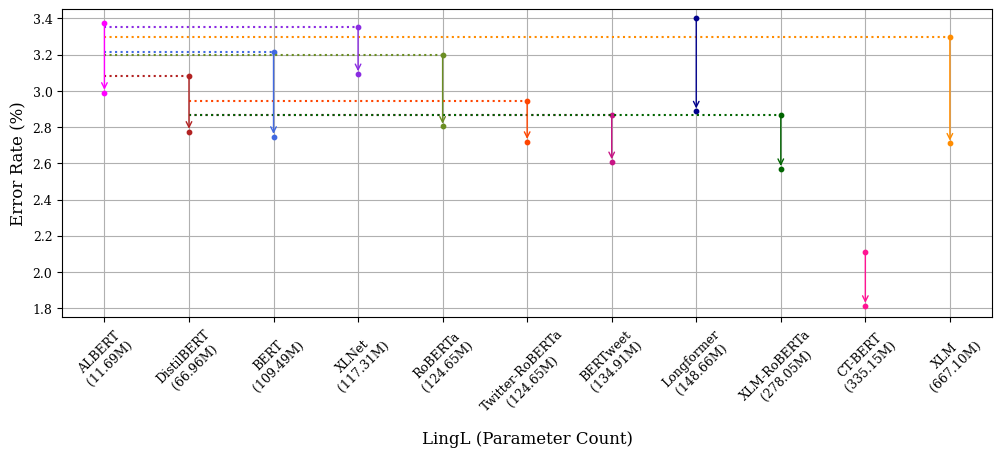

In [185]:
# exclude = lambda l: [x for i, x in enumerate(l) if i not in set()]
# plt.scatter(exclude(params), exclude(acc), color='blue')
# plt.scatter(exclude(params), exclude(acc_app), color='green')
# plt.show()

# import matplotlib as mpl
# colors = iter(mpl.colormaps['Paired'](np.delete(np.linspace(0.,1.,12),10)))
# colors = iter(mpl.colormaps['Paired'](np.linspace(0.,1.,len(params))))
colors = ['magenta', 'firebrick', 'royalblue', 'blueviolet', 'olivedrab',
          'orangered', 'mediumvioletred', 'darkblue', 'darkgreen', 'deeppink',
          'darkorange', 
]

plt.figure(figsize=(12,4))

exclude = lambda l: [x for i, x in enumerate(l) if i not in set()]
for i, (p, x, y, c) in enumerate(zip(params, acc, acc_app, colors)):
    # plt.arrow(i, 1-x, 0, x-y, length_includes_head=True, head_length=0., head_starts_at_zero=False, width=0.05, head_width=0.5, color=c)
    plt.scatter(i, 100*(1-x), s=10, color=c)
    plt.scatter(i, 100*(1-y), s=10, color=c)
    plt.annotate("", xy=(i,100*(1-y)), xytext=(i,100*(1-x)), arrowprops=dict(color=c,arrowstyle="->"))
# plt.plot(range(len(params)), [100*(1-x) for x in acc], color='green')
# plt.plot(range(len(params)), [100*(1-x) for x in acc_app], color='blue')
i=1; plt.hlines([100*(1-acc[i])], xmin=0, xmax=i, colors=colors[i], linestyle='dotted')
i=2; plt.hlines([100*(1-acc[i])], xmin=0, xmax=i, colors=colors[i], linestyle='dotted')
i=3; plt.hlines([100*(1-acc[i])], xmin=0, xmax=i, colors=colors[i], linestyle='dotted')
i=4; plt.hlines([100*(1-acc[i])], xmin=0, xmax=i, colors=colors[i], linestyle='dotted')
i=5; plt.hlines([100*(1-acc[i])], xmin=1, xmax=i, colors=colors[i], linestyle='dotted')
i=6; plt.hlines([100*(1-acc[i])], xmin=1, xmax=i, colors=colors[i], linestyle='dotted')
i=8; plt.hlines([100*(1-acc[i])], xmin=1, xmax=i, colors=colors[i], linestyle='dotted')
i=10; plt.hlines([100*(1-acc[i])], xmin=0, xmax=i, colors=colors[i], linestyle='dotted')
plt.xticks(ticks=range(len(params)), labels=[f'{m}\n({p/10**6:.2f}M)' for m, (p, _) in sorted_index], rotation=45, font=FONTDICT['family'], size=9)
plt.yticks(font=FONTDICT['family'], size=9)
plt.xlabel('LingL (Parameter Count)', font=FONTDICT['family'], size=12)
plt.ylabel('Error Rate (%)', font=FONTDICT['family'], size=12)
plt.ylim(1.75, 3.45)
plt.rc('axes', axisbelow=True)
plt.grid()
plt.show()

In [191]:
from itertools import combinations

def perc_change(v1, v2):
    return round(100 * (v1-v2) / v2, 3)

print('base model_j better than base model_i, but\n\tmodel_i with linguistic features better than model_j with linguistic features'.upper())
improvements = list()
for i, j in combinations(range(len(index)), 2):
    if (dataframe['acc'][i][0] < dataframe['acc'][j][0]) and (dataframe['acc-appended'][i][0] > dataframe['acc-appended'][j][0]):
        improvements.append((i, j))
    elif (dataframe['acc'][i][0] > dataframe['acc'][j][0]) and (dataframe['acc-appended'][i][0] < dataframe['acc-appended'][j][0]):
        improvements.append((j, i))
for k, (i, j) in enumerate(improvements, 1):
    if parameters[index[i]][0] > parameters[index[j]][0]:
        continue
    print(f"{k}. {index[i]} > {index[j]}:",
        f"\n\t{perc_change(1-dataframe['acc'][j][0], 1-dataframe['acc'][i][0])}% ->",
        f"+{perc_change(1-dataframe['acc-appended'][j][0], 1-dataframe['acc-appended'][i][0])}%",
        f"\n\t{parameters[index[j]][0]/parameters[index[i]][0]:.2f} times smaller model"
    )

print('\nbase model_j better than base model_i, but\n\tmodel_i with linguistic features better than base model_j'.upper())
improvements = list()
for i, j in combinations(range(len(index)), 2):
    if dataframe['acc'][i][0] < dataframe['acc'][j][0] < dataframe['acc-appended'][i][0]:
        improvements.append((i, j))
    elif dataframe['acc'][j][0] < dataframe['acc'][i][0] < dataframe['acc-appended'][j][0]:
        improvements.append((j, i))
for k, (i, j) in enumerate(improvements, 1):
    if parameters[index[i]][0] > parameters[index[j]][0]: # or {index[i], index[j]}.intersection({'BERTweet', 'CT-BERT', 'Twitter-RoBERTa'}):
        continue
    print(f"{k}. {index[i]} > {index[j]}:".ljust(34, " "),
        f"{perc_change(1-dataframe['acc'][j][0], 1-dataframe['acc'][i][0])}%".ljust(8, " "),
        f"-> +{perc_change(1-dataframe['acc'][j][0], 1-dataframe['acc-appended'][i][0])}%".ljust(11, " "),
        f"with model size ratio {parameters[index[j]][0]/parameters[index[i]][0]:.2f}"
    )

print('\nbase model_j better than base model_i, and\n\tbase model_j better than model_i with linguistic features'.upper())
improvements = list()
for i, j in combinations(range(len(index)), 2):
    if dataframe['acc'][i][0] < dataframe['acc'][j][0] > dataframe['acc-appended'][i][0]:
        improvements.append((i, j))
    elif dataframe['acc'][j][0] < dataframe['acc'][i][0] > dataframe['acc-appended'][j][0]:
        improvements.append((j, i))
for k, (i, j) in enumerate(improvements, 1):
    if parameters[index[i]][0] > parameters[index[j]][0]: # or {index[i], index[j]}.intersection({'BERTweet', 'CT-BERT', 'Twitter-RoBERTa'}):
        continue
    print(f"{k}. {index[i]} > {index[j]}:".ljust(34, " "),
        f"{perc_change(1-dataframe['acc'][j][0], 1-dataframe['acc'][i][0])}%".ljust(8, " "),
        f"-> {perc_change(1-dataframe['acc'][j][0], 1-dataframe['acc-appended'][i][0])}%".ljust(11, " "),
        f"with model size ratio {parameters[index[j]][0]/parameters[index[i]][0]:.2f}"
    )

BASE MODEL_J BETTER THAN BASE MODEL_I, BUT
	MODEL_I WITH LINGUISTIC FEATURES BETTER THAN MODEL_J WITH LINGUISTIC FEATURES
2. ALBERT > XLNet: 
	-0.554% -> +3.438% 
	10.04 times smaller model
4. BERT > RoBERTa: 
	-0.581% -> +2.041% 
	1.14 times smaller model

BASE MODEL_J BETTER THAN BASE MODEL_I, BUT
	MODEL_I WITH LINGUISTIC FEATURES BETTER THAN BASE MODEL_J
1. ALBERT > BERT:                  -4.709%  -> +7.5%    with model size ratio 9.37
2. ALBERT > DistilBERT:            -8.587%  -> +3.125%  with model size ratio 5.73
4. ALBERT > RoBERTa:               -5.263%  -> +6.875%  with model size ratio 10.67
5. ALBERT > XLM:                   -2.216%  -> +10.313% with model size ratio 57.09
6. ALBERT > XLNet:                 -0.554%  -> +12.187% with model size ratio 10.04
7. BERT > BERTweet:                -10.756% -> +4.422%  with model size ratio 1.23
10. BERT > RoBERTa:                -0.581%  -> +16.327% with model size ratio 1.14
11. BERT > Twitter-RoBERTa:        -8.43%   -> +7.143%  

In [5]:
test_accs = list()

for dataset in datasets:
    results, _ = get_results(dataset, index)
    test_accs.append(list())
    for model in index:
        scores = list()
        for run in results[model]:
            val_data = run['validation']
            idxs = list(range(jump, len(val_data['batch'])+jump, jump))
            val_metrics = fn_map[metric](val_data, idxs, jump)
            best_val_metric = max(val_metrics)
            test_data = run['testing']
            test_metrics = fn_map[metric](test_data, idxs, jump)
            best_test_metric = 0.
            for val_metric, test_metric in zip(val_metrics, test_metrics):
                if val_metric == best_val_metric:
                    best_test_metric = max(test_metric, best_test_metric)
            scores.append(best_test_metric)
        test_accs[-1].append(scores)

bplot_data = [None] * (2*len(index))
bplot_data[::2] = test_accs[0]
bplot_data[1::2] = test_accs[1]

In [10]:
for model, acc, acc_appended in zip(index, *test_accs):
    mean_acc, mean_acc_appended = map(np.mean, (acc, acc_appended))
    max_acc, max_acc_appended = map(np.max, (acc, acc_appended))
    std_acc, std_acc_appended = map(np.std, (acc, acc_appended))
    print(f'{model} & {100*(1-mean_acc):.2f} & {100*(1-max_acc):.2f} & {100*(std_acc):.2f} & {100*(1-mean_acc_appended):.2f} & {100*(1-max_acc_appended):.2f} & {100*(std_acc_appended):.2f} & {100*(mean_acc_appended-mean_acc)/(1-mean_acc):.2f} \\\\ \\hline')

ALBERT & 3.37 & 3.18 & 0.16 & 2.99 & 2.80 & 0.11 & 11.36 \\ \hline
BERT & 3.21 & 3.04 & 0.20 & 2.75 & 2.57 & 0.10 & 14.53 \\ \hline
BERTweet & 2.87 & 2.76 & 0.06 & 2.61 & 2.48 & 0.13 & 9.12 \\ \hline
CT-BERT & 2.11 & 1.87 & 0.13 & 1.81 & 1.68 & 0.08 & 14.02 \\ \hline
DistilBERT & 3.08 & 2.90 & 0.17 & 2.78 & 2.66 & 0.06 & 10.00 \\ \hline
Longformer & 3.40 & 3.18 & 0.19 & 2.89 & 2.76 & 0.08 & 15.11 \\ \hline
RoBERTa & 3.20 & 3.08 & 0.22 & 2.80 & 2.38 & 0.22 & 12.28 \\ \hline
Twitter-RoBERTa & 2.94 & 2.90 & 0.04 & 2.72 & 2.52 & 0.11 & 7.62 \\ \hline
XLM & 3.30 & 2.94 & 0.31 & 2.71 & 2.48 & 0.14 & 17.85 \\ \hline
XLM-RoBERTa & 2.87 & 2.71 & 0.10 & 2.57 & 2.38 & 0.12 & 10.42 \\ \hline
XLNet & 3.36 & 3.22 & 0.10 & 3.09 & 2.94 & 0.12 & 7.80 \\ \hline


In [10]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
bplot = axs.boxplot(bplot_data, patch_artist=True)
colors = ['lightblue', 'lightgreen']
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[i%2])
fontdict = {'family':'serif', 'color':'black', 'weight':'normal', 'size':14}
axs.set_ylabel('Accuracy (%)', fontdict=fontdict, labelpad=12)
plt.xticks(ticks=np.arange(2.5, 23, 2), labels=index, rotation=15, **fontdict)
dx = -45/72; dy = 0/72
offset = mlp.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in axs.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
axs.grid(which='major', color='#AAAAAA', linewidth=0.8)
acc = mlp.patches.Patch(color='lightblue', label='AAAI-Constraint')
acc_a = mlp.patches.Patch(color='lightgreen', label='AAAI-Constraint-Appended')
plt.legend(handles=[acc, acc_a], prop={'family':'serif', 'size': 14})
plt.show()

: 